## Utilizzo della tecnica di Global Pooling
## in una rete neurale artificiale convolutiva

[**Dataset utilizzato**](https://huggingface.co/datasets/microsoft/cats_vs_dogs)

![Dogs vs Cats](../../images//woof_meow.jpg)

In [ ]:
# importazione delle librerie
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
# per caricare il dataset da repository huggingface
from datasets import load_dataset

c:\Users\felip\Desktop\MLMC\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
# 1. Carica il dataset da Hugging Face
dataset = load_dataset("microsoft/cats_vs_dogs", split="train")
dataset = dataset.with_format("tf")

# 2. Estrai informazioni simili a `ds_info`
num_examples = len(dataset)
label_names = dataset.features["labels"].names
image_shape = dataset[0]["image"].shape

info = {
    "num_examples": num_examples,
    "label_names": label_names,
    "image_shape": image_shape,
}
print("INFO:")
print(info)

# 3. Esegui lo split 90% train / 10% validation
split_ds = dataset.train_test_split(test_size=0.1, seed=42)
train_ds_hf = split_ds["train"]
val_ds_hf = split_ds["test"]

# 4. Converte Hugging Face Dataset in tf.data.Dataset
def hf_to_tfds(hf_dataset):
    def gen():
        for example in hf_dataset:
            image = example["image"]

            # Se immagine è grayscale (H, W), convertila in RGB
            if image.ndim == 2:
                image = tf.stack([image] * 3, axis=-1)

            # Se immagine ha 1 canale (H, W, 1)
            elif image.shape[-1] == 1:
                image = tf.image.grayscale_to_rgb(image)

            # Se immagine ha 4 canali (es. RGBA), rimuovi il canale alfa
            elif image.shape[-1] == 4:
                image = image[..., :3]  # Prendi solo i primi 3 canali (RGB)

            label = tf.convert_to_tensor(example["labels"])
            yield image, label

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64),
        )
    )



train_tfds = hf_to_tfds(train_ds_hf)
val_tfds = hf_to_tfds(val_ds_hf)

INFO:
{'num_examples': 23410, 'label_names': ['cat', 'dog'], 'image_shape': TensorShape([375, 500, 3])}


In [43]:
splits = {
    "train[:90%]": train_ds_hf,
    "train[90%:]": val_ds_hf,
}

examples = len(splits["train[:90%]"])

print(f"Numero di esempi nel train set: {examples}")
print(f"Numero di esempi nel validation set: {len(splits['train[90%:]'])}")

Numero di esempi nel train set: 21069
Numero di esempi nel validation set: 2341


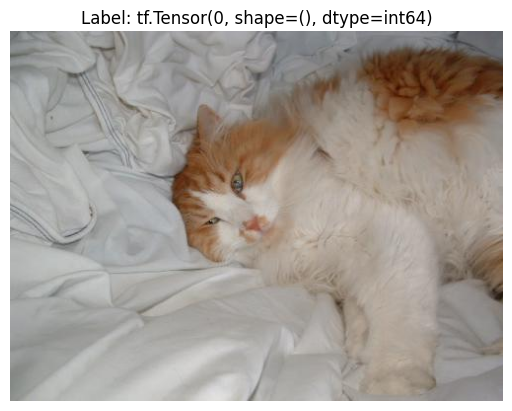

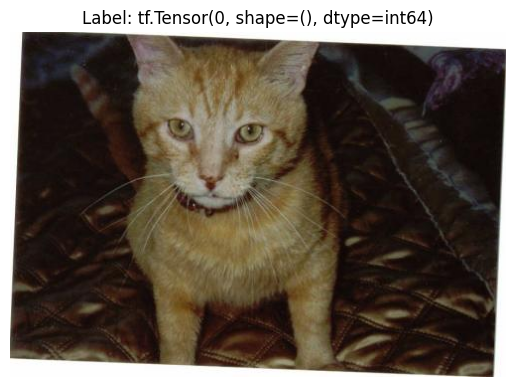

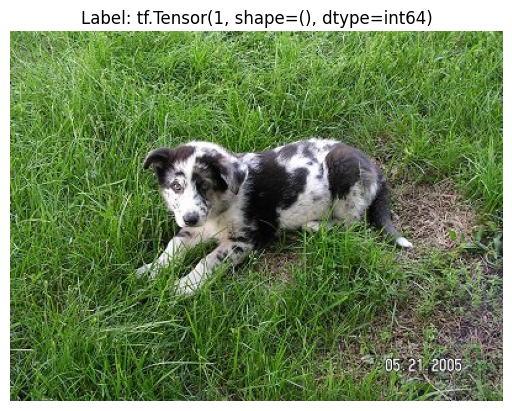

In [44]:
# label 0 -> "cat", label 1 -> "dog"
for image, label in train_tfds.take(3):
    plt.figure()
    plt.imshow(image.numpy())
    plt.title(f"Label: {str(label)}")
    plt.axis("off")
    plt.show()


In [45]:
IMAGE_SIZE = 100

def pre_process_image(image, label):
    image = tf.cast(image, tf.float32)        # Converti in float32
    image = image / 255.0                      # Normalizza
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # Resize
    return image, label

In [46]:
BATCH_SIZE = 64
examples = len(train_ds_hf)  # numero di esempi nel training set (90%)
# Calcola il numero di steps da fare per epoca
steps_per_epoch = examples // BATCH_SIZE # divisione intera

# Applica preprocessing, shuffle, repeat e batch

# per la fase di training, una volta che abbiamo preprocesato i dati con la callback pre_process_image,
# andiamo a mescolare le immagini del dataset di training con una dimensione del buffer pari al numero di esempi presenti nel dataset
# una volta terminata una fase di training ripetiamo il mescolamento per la fase successiva
# poi specificiamo la dimensione del batch da utilizzare in fase di training pari a 64
ds_train = train_tfds.map(pre_process_image).shuffle(examples).repeat().batch(BATCH_SIZE)

# nella fase di test andiamo solo a specificare la dimensione del batch da utilizzare in fase di test che avviene una volta sola
ds_val = val_tfds.map(pre_process_image).batch(BATCH_SIZE)

![CNN](../../images/CNN.png)

In [47]:
## Creiamo la nostra architettura di rete

model = tf.keras.Sequential(name='Conv2D_Dense')
model.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) # downsampling normale

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) # downsampling normale

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) # downsampling normale

# dopo i blocchi convolutivi andiamo a schiacciare le immagini in un vettore
model.add(layers.Flatten())

model.add(layers.BatchNormalization())
# Aggiungiamo un layer denso con 64 neuroni dove ogni neurone è connesso a tutti i valori del vettore di input
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.BatchNormalization())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.Dense(1)) # layer di output con un neurone per la classificazione binaria (cat vs dog)
model.add(layers.Activation('sigmoid'))  # attivazione sigmoid per classificazione binaria 

# Compiliamo il modello
# ottimizzatore -> come aggiornare i pesi della rete
# loss -> come misurare qunato il modello sbaglia
# metrics -> come misurare le performance del modello, 'accuracy' calcola la percentuale di etichette corrette durante il training/validation
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "Conv2D_Dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12800)          │        51,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 969,089 (3.70 MB)

 Trainable params: 942,913 (3.60 MB)

 Non-trainable params: 26,176 (102.25 KB)

Dal model.summary() notiamo che il maggior numero di parametri (819'264) si trova tra il livello `Flatten` ed i 64 neuroni del primo livello `Dense`.

Questo perchè ogni valore del vettore `Flatten` viene "collegato" a ognuno dei 64 neuroni, ad esempio se il vettore Flatten ha 20'000 valori ciascuno di essi è "collegato" a ognuno dei 64 neuroni. Ogni collegamento rappresenta un parametro della rete pertanto in questo caso avremo 20'000 * 64 = 1'280'000 parametri.

Nella nostra rete il vettore `Flatten` è di dimensione (12'800) quindi appunto abbiamo 12'800 * 64 + 64 (bias di ogni neurone) = 819'264 parametri.

In [48]:
# addestriamo il modello sul dataset di training
history = model.fit(
    ds_train,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    # dataset di validazione
    validation_data=ds_val
)

Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.6913 - loss: 0.5821 - val_accuracy: 0.5775 - val_loss: 0.7698
Epoch 2/25


c:\Users\felip\Desktop\MLMC\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


329/329 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8261 - loss: 0.3883 - val_accuracy: 0.7698 - val_loss: 0.4966
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.8709 - loss: 0.3007 - val_accuracy: 0.8120 - val_loss: 0.4433
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 311s 947ms/step - accuracy: 0.9093 - loss: 0.2261 - val_accuracy: 0.8197 - val_loss: 0.4154
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9436 - loss: 0.1504 - val_accuracy: 0.7847 - val_loss: 0.5766
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.9608 - loss: 0.1092 - val_accuracy: 0.7676 - val_loss: 0.6886
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 289s 879ms/step - accuracy: 0.9730 - loss: 0.0775 - val_accuracy: 0.8488 - val_loss: 0.4263
Epoch 8/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.9822 - loss: 0.0502 - val_accuracy: 0.8432 - val_loss: 0.5089
Epoch 9/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.9854 - loss: 0.0411 - val_accuracy:

In [49]:
print("Accuratezza in test", model.evaluate(ds_val)[1] * 100)

37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 346ms/step - accuracy: 0.8448 - loss: 0.5992
Accuratezza in test 84.19479131698608


c:\Users\felip\Desktop\MLMC\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [50]:
### Sostituzione dei layer Flatten e Dense con il livello di Global Pooling

model_gp = tf.keras.Sequential(name="Conv2D_GlobalMAxPooling")

#input 
model_gp.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Activation('relu'))
model_gp.add(layers.MaxPooling2D(pool_size=(2, 2)))  # downsampling normale

model_gp.add(layers.Conv2D(64, (3, 3)))
model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Activation('relu'))
model_gp.add(layers.MaxPooling2D(pool_size=(2, 2)))  # downsampling normale

model_gp.add(layers.Conv2D(128, (3, 3)))
model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Activation('relu'))
model_gp.add(layers.MaxPooling2D(pool_size=(2, 2)))  # downsampling normale

# Global Max Pooling che prende il valore massimo di ogni feature map
model_gp.add(layers.GlobalMaxPool2D()) # vettore di output con dimensione (1x1x128)

model_gp.add(layers.BatchNormalization())
model_gp.add(layers.Dense(1))
model_gp.add(layers.Activation('sigmoid'))  # attivazione sigmoid per classificazione binaria

# compiliamo il modello
model_gp.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_gp.summary()

c:\Users\felip\Desktop\MLMC\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Conv2D_GlobalMAxPooling"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,785 (370.25 KB)

 Trainable params: 94,081 (367.50 KB)

 Non-trainable params: 704 (2.75 KB)

Come previsto con il `Global Pooling` otteniamo una rete con molti parametri in meno (94'785 contro i 969'089), grazie alla sostituizione dei layer di `Flatten` che appiattiva tutte le immagini in un unico grande vettore di cui ciascun valore si collegava a ciascuno dei 64 neuroni del livello `Dense` causando una esplosione di parametri senza contare anche i parametri tra i successivi 2 livelli `Dense`.


Come vediamo nella rete il livello precedente al GlobalMaxPooling ha 128 Feature Map 10x10. Dunque il GlobalMaxPooling prende il valore massimo da queste 128 Feature Map ottenendo una vettore con 128 valori dove ciascuno di essi rappresenta il valore predominante all'interno di ciascuna Feature Map.

Un'altra considerazione importante è che nella rete senza il GlobalMaxPooling durante la fase di backpropagation il grosso delle correzioni dei pesi avviene infatti dove sono presenti il maggior numero di pesi, ovvero tra il Flatten ed il primo Dense. Quindi la maggior parte dell'errore viene rilevato in questa parte della rete che è quasi in cocomitanza all'uscita dell'output. Quindi l'errore che arriva ai primi livelli convolutivi sarà minore dato che il grosso dell'errore viene corretto già nei livelli vicini all'uscita che sono appunto il livelli Dense.

Tutto questo **non** avviene nella fase di backprogation della rete che usa il GlobalMaxPooling, il che significa che possiamo corregere l'errore in maniera più importante nei livelli iniziali della rete (nei lovelli convolutivi) cotrariamente a come avviene nella rete con Flatten e Dense dove i livelli iniziali subiscono una correzione molto più debole.


Inoltre, con la rete con Global Pooling abbiamo un tempo di addestramento molto inferiore.

In [51]:
hystory_gp = model_gp.fit(
    ds_train,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=ds_val
)

Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 442s 920ms/step - accuracy: 0.6975 - loss: 0.5782 - val_accuracy: 0.5092 - val_loss: 0.9532
Epoch 2/25


c:\Users\felip\Desktop\MLMC\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


329/329 ━━━━━━━━━━━━━━━━━━━━ 298s 907ms/step - accuracy: 0.8185 - loss: 0.3980 - val_accuracy: 0.8210 - val_loss: 0.3899
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 288s 876ms/step - accuracy: 0.8723 - loss: 0.3025 - val_accuracy: 0.8197 - val_loss: 0.3902
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 280s 851ms/step - accuracy: 0.9023 - loss: 0.2358 - val_accuracy: 0.8637 - val_loss: 0.3117
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 276s 841ms/step - accuracy: 0.9256 - loss: 0.1839 - val_accuracy: 0.8633 - val_loss: 0.3172
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 271s 824ms/step - accuracy: 0.9430 - loss: 0.1518 - val_accuracy: 0.8654 - val_loss: 0.3088
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 265s 807ms/step - accuracy: 0.9480 - loss: 0.1359 - val_accuracy: 0.8616 - val_loss: 0.3465
Epoch 8/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 260s 791ms/step - accuracy: 0.9692 - loss: 0.0918 - val_accuracy: 0.8232 - val_loss: 0.5055
Epoch 9/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 261s 793ms/step - accuracy: 0.9716 - loss: 0.08

In [52]:
print("Accuratezza in test con Global Max Pooling", model_gp.evaluate(ds_val)[1] * 100)

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 360ms/step - accuracy: 0.7001 - loss: 1.4732
Accuratezza in test con Global Max Pooling 69.62836384773254


c:\Users\felip\Desktop\MLMC\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


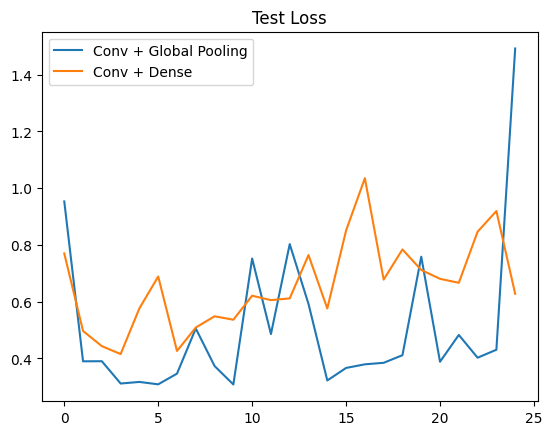

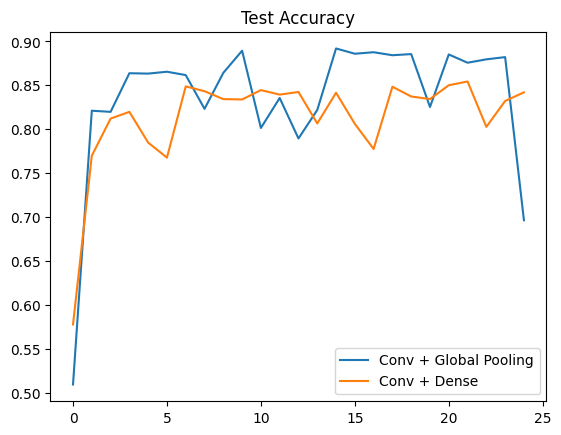

In [54]:
plt.plot(hystory_gp.history['val_loss'], label='Conv + Global Pooling')
plt.plot(history.history['val_loss'], label='Conv + Dense')
plt.title('Test Loss')
plt.legend()
plt.show()

plt.plot(hystory_gp.history['val_accuracy'], label='Conv + Global Pooling')
plt.plot(history.history['val_accuracy'], label='Conv + Dense')
plt.title('Test Accuracy')
plt.legend()
plt.show()